In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import RobertaTokenizer, RobertaModel
# from matplotlib import style
import random
import pickle
# style.use("dark_background")
seed_val = 994
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
device=torch.device("cuda")

In [2]:
# %history
train_df=pd.read_csv("./MELD/data/MELD/train_sent_emo.csv")
val_df=pd.read_csv("./MELD/data/MELD/dev_sent_emo.csv")
test_df=pd.read_csv("./MELD/data/MELD/test_sent_emo.csv")


train_df.head()

# file = open("IEMOCAP_features_bert.pkl",'rb')
# object_file = pickle.load(file)
# file.close()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my company’s tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You must’ve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So let’s talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


0    4710
4    1743
1    1205
6    1109
3     683
5     271
2     268
Name: Emotion, dtype: int64


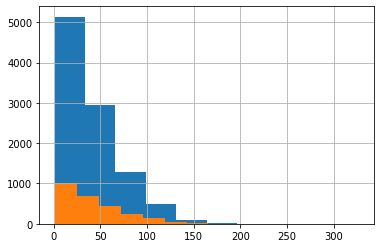

In [3]:

mapping ={'neutral':0, 'surprise':1, 'fear':2, 'sadness':3, 'joy':4, 'disgust':5, 'anger':6}

# mapping2={"Chandler":0,"Phoebe":1,"Monica":2,"Ross":3,"Joey":4,"Rachel":5}

train_df=train_df.replace({"Emotion":mapping})# mapping labels to integer
val_df=val_df.replace({"Emotion":mapping})
test_df=test_df.replace({"Emotion":mapping})

# train_df=train_df.replace({"Speaker":mapping2})# mapping labels to integer
# val_df=val_df.replace({"Speaker":mapping2})
# test_df=test_df.replace({"Speaker":mapping2})


train_text=train_df["Utterance"].tolist()
val_text=val_df["Utterance"].tolist()
test_text=test_df["Utterance"].tolist()


train_labels=train_df["Emotion"]
val_labels=val_df["Emotion"]
test_labels=test_df["Emotion"]

train_dia_id=train_df["Dialogue_ID"]
val_dia_id=val_df["Dialogue_ID"]
test_dia_id=test_df["Dialogue_ID"]

train_speaker=train_df["Speaker"]
val_speaker=val_df["Speaker"]
test_speaker=test_df["Speaker"]

# print(train_text,train_labels)

len_train=[len(j) for j in train_text]
len_test=[len(i) for i in test_text]

pd.Series(len_train).hist()
pd.Series(len_test).hist()

print(train_df.Emotion.value_counts())



In [4]:
print(train_text[6])
print(train_df["Speaker"].value_counts())



I see.
Joey                1510
Ross                1458
Rachel              1435
Phoebe              1321
Monica              1299
                    ... 
Phoebe/Waitress        1
Vince                  1
Gary Collins           1
Hold Voice             1
Front Desk Clerk       1
Name: Speaker, Length: 260, dtype: int64


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
model = RobertaModel.from_pretrained('roberta-large')

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
tokens_train=tokenizer(train_text,
                                         max_length=80,
                                         padding=True,
                                         truncation=True)

tokens_val=tokenizer(val_text,
                                         max_length=80,
                                         padding=True,
                                         truncation=True)

tokens_test=tokenizer(test_text,
                                         max_length=80,
                                         padding=True,
                                         truncation=True)

In [7]:
train_seq=torch.tensor(tokens_train["input_ids"])
train_mask=torch.tensor(tokens_train["attention_mask"])
train_label=torch.tensor(train_labels.tolist())

val_seq=torch.tensor(tokens_val["input_ids"])
val_mask=torch.tensor(tokens_val["attention_mask"])
val_label=torch.tensor(val_labels.tolist())

test_seq=torch.tensor(tokens_test["input_ids"])
test_mask=torch.tensor(tokens_test["attention_mask"])
test_label=torch.tensor(test_labels.tolist())

In [8]:
from torch.utils.data import DataLoader,TensorDataset,RandomSampler, SequentialSampler
batch_size=32

train_data=TensorDataset(train_seq,train_mask,train_label)
train_sampler=SequentialSampler(train_data)
train_dataloader=DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

val_data=TensorDataset(val_seq,val_mask,val_label)
val_sampler=SequentialSampler(val_data)
val_dataloader=DataLoader(val_data,sampler=val_sampler,batch_size=batch_size)

test_data=TensorDataset(test_seq,test_mask,test_label)
print(len(test_data[0][0]))
test_sampler=SequentialSampler(test_data)
test_dataloader=DataLoader(test_data,sampler=test_sampler,batch_size=batch_size)
print(len(test_dataloader))

65
82


In [9]:
from tqdm.notebook import tqdm_notebook
print(type(train_speaker))
# modules=[bert.encoder.layer[:1]]
# for module in modules:
#     for param in module.parameters():
#         param.requires_grad=False

# for name, param in list(bert.named_parameters())[:-79]: 
#     print('I will be frozen: {}'.format(name)) 
#     param.requires_grad = False


<class 'pandas.core.series.Series'>


In [10]:
# model=BERT_model(bert)
# model=AutoModel.from_pretrained("roberta-large")

model=model.to(device)

In [ ]:
torch.cuda.empty_cache()
model.eval()
train_embed=[]
val_embed=[]
test_embed=[]
with torch.no_grad():
    for step,batch in tqdm_notebook(enumerate(test_dataloader),total=len(test_dataloader)):        
            
        batch=[r.to(device) for r in batch]
        
        sent_id,mask,labels=batch
                
        preds=model(sent_id,mask)[1]    # size  16*1024 batxh_size*encoding


        preds=preds.detach().cpu().numpy()

        test_embed.append(preds)
        
    for step,batch in tqdm_notebook(enumerate(val_dataloader),total=len(val_dataloader)):        
            
        batch=[r.to(device) for r in batch]
        
        sent_id,mask,labels=batch
                
        preds=model(sent_id,mask)[1]    # size  16*1024 batxh_size*encoding

        preds=preds.detach().cpu().numpy()

        val_embed.append(preds)
        
    for step,batch in tqdm_notebook(enumerate(train_dataloader),total=len(train_dataloader)):        
            
        batch=[r.to(device) for r in batch]
        
        sent_id,mask,labels=batch
                
        preds=model(sent_id,mask)[1]    # size  16*1024 batxh_size*encoding


        preds=preds.detach().cpu().numpy()

        train_embed.append(preds)
        
    train_embed=np.concatenate(train_embed,axis=0)
    val_embed=np.concatenate(val_embed,axis=0)
    test_embed= np.concatenate(test_embed,axis=0)

 


In [ ]:
# total_preds= np.concatenate(total_preds,axis=0)
print(len(train_embed))
print(len(val_embed))
print(len(test_embed))
train_embed=torch.tensor(train_embed)  #changing to tensor
val_embed=torch.tensor(val_embed)
test_embed=torch.tensor(test_embed)
print(train_embed.shape)


In [ ]:
import dgl
from dgl.nn import GraphConv
import graph4nlp


In [ ]:
class GCN(nn.Module):
    def __init__(self,in_f,o_f,num_label):
        super().__init__()
        self.conv1=GraphConv(in_f,o_f)
        self.conv2=GraphConv(in_f,o_f)
        self.conv3=GraphConv(in_f,o_f)
        self.conv4=GraphConv(in_f,o_f)
        self.conv5=GraphConv(in_f,o_f)
        self.fc1=nn.Linear(2*o_f,num_label)
        
    def forward(self,g,in_f):
        h=self.conv1(g,in_f)
        h=F.relu(h)
        h=self.conv2(g,h)
        h=F.relu(h)
        h=self.conv3(g,h)
        h=F.relu(h)
        h=self.conv4(g,h)
        h=F.relu(h)
        h=self.conv5(g,h)
        h=F.relu(h)
        h=self.fc1(torch.cat([in_f,h] ,dim=-1))[-1]
#         h=F.softmax(h,dim=1)
        
        return h
        
        
        

In [ ]:
# train_speaker=train_speaker[1:]

In [ ]:
graphs=[]
# u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
# g=dgl.graph((u,v))
# g.ndata["emb"]=train_embed[:g.num_nodes()]
# print(g.device)
for i,e in enumerate(train_embed):
    if i>= (5):
#         speakers=train_speaker[i-5:i+1]
#         print(speakers)
#         speakers=speakers.unique()
#         print(speakers)
#         main_speakers=[e for e in speakers if isinstance(e,int)]  
#         for e in main_speakers:
#             print(e)
        u,v=torch.tensor([0,1,2,3,4]),torch.tensor([1,2,3,4,5])
#         print(i)
        g=dgl.graph((u,v))
        g.ndata["emb"]=train_embed[i-5:i+1]
        
        graphs.append(g)
    
    if i==4:
        u,v=torch.tensor([0,1,2,3]),torch.tensor([1,2,3,4])
        g=dgl.graph((u,v))
        g.ndata["emb"]=train_embed[0:5]
        graphs.append(g)
    
    if i==3:
        u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
        g=dgl.graph((u,v))
        g.ndata["emb"]=train_embed[0:4]
        graphs.append(g)
        
    if i==2:
        u,v=torch.tensor([0,1]),torch.tensor([1,2])
        g=dgl.graph((u,v))
        g.ndata["emb"]=train_embed[0:3]
        graphs.append(g)
    if i==1:
        u,v=torch.tensor([0]),torch.tensor([1])
        g=dgl.graph((u,v))
        g.ndata["emb"]=train_embed[0:2]
        graphs.append(g)
#     if i==0:
#         u,v=torch.tensor([0]),torch.tensor([0])
#         g=dgl.graph((u,v),num_nodes=1)
#         g.ndata["emb"]=torch.tensor([train_embed[0]])

In [ ]:
print(len(graphs))
print(graphs[1].ndata["emb"],graphs[2].ndata["emb"])
# torch.manual_seed(1)
# a=torch.rand(2)
# torch.manual_seed(1)
# b=torch.rand(2)
# f=[train_embed[0]]
# f=[*range(0,2,1)]
# print(len(f))

In [ ]:
model=GCN(1024,1024,7)
opt = torch.optim.Adam(model.parameters())

In [ ]:
train_labels=train_df["Emotion"]
print(train_label.shape)
# train_label=train_label[1:]


In [ ]:
import torch.nn.functional as F
loss_fn = nn.CrossEntropyLoss()
loss_tot=0
for epoch in range(50):
    for i,graph in tqdm_notebook(enumerate(graphs),total=len(graphs)):
        model.train()
        node_features=graph.ndata["emb"]
        graph=dgl.add_self_loop(graph)
        logits = model(graph, node_features)
        logits=torch.unsqueeze(logits,0)
        label=torch.unsqueeze(train_label[i],0)
        loss=loss_fn(logits,label)
        loss_tot+=loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
    print("epoch",epoch)
    print(loss_tot)
    loss_tot=0
    
# graph = dgl.add_self_loop(graphs[1])
# loss = F.cross_entropy(logits, train_label[i])
# logits = model(graph, graph.ndata["emb"])
# print()

In [37]:
print(logits)


tensor([[20.6336, 17.8999, 14.9298, 17.6984, 18.9020, 20.8048, 17.9433]],
       grad_fn=<UnsqueezeBackward0>)


In [98]:
# logits = torch.unsqueeze(logits,0)
# print(logits.shape)

torch.Size([1, 7])


In [38]:
# x=torch.unsqueeze(train_label[1],0)
# print(x.shape)
# print(loss_fn(logits, x))
# print(train_label[9].shape)
print(len(test_embed))
# test_embed=test_embed[1:]
# print(train_label[9].shape)
print(len(test_embed))

2610
2610


In [39]:
graphs_test=[]
# u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
# g=dgl.graph((u,v))
# g.ndata["emb"]=train_embed[:g.num_nodes()]
# print(g.device)
for i,e in enumerate(test_embed):
    if i>= (5):
        u,v=torch.tensor([0,1,2,3,4]),torch.tensor([1,2,3,4,5])
#         print(i)
        g=dgl.graph((u,v))
        g.ndata["emb"]=test_embed[i-5:i+1]
#         speakers=train_speaker[i-3:i+1]
# #         print(speakers)
#         speakers=speakers.unique()
#         main_speakers=[e for e in speakers if isinstance(e,int)]
#         for e in main_speakers
#         print()
        graphs_test.append(g)
    
    if i==4:
        u,v=torch.tensor([0,1,2,3]),torch.tensor([1,2,3,4])
        g=dgl.graph((u,v))
        g.ndata["emb"]=test_embed[0:5]
        graphs_test.append(g)
        
    if i==3:
        u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
        g=dgl.graph((u,v))
        g.ndata["emb"]=test_embed[0:4]
        graphs_test.append(g)
    if i==2:
        u,v=torch.tensor([0,1]),torch.tensor([1,2])
        g=dgl.graph((u,v))
        g.ndata["emb"]=test_embed[0:3]
        graphs_test.append(g)
    if i==1:
        u,v=torch.tensor([0]),torch.tensor([1])
        g=dgl.graph((u,v))
        g.ndata["emb"]=test_embed[0:2]
        graphs_test.append(g)

In [41]:
print(len(graphs_test
         ))
print(len(test_label))

2609
2609


In [42]:
model.eval()
preds=[]
with torch.no_grad():
    for i,graph in tqdm_notebook(enumerate(graphs_test),total=len(graphs_test)):

        node_features=graph.ndata["emb"]
        graph=dgl.add_self_loop(graph)
        logits = model(graph, node_features)
        logits=torch.unsqueeze(logits,0)
        pred=logits.detach().cpu().numpy()
#         print(pred)
        pred=np.argmax(pred,axis=1)
        preds.append(pred)
        
    

  0%|          | 0/2609 [00:00<?, ?it/s]

In [43]:
# graph=graphs_test[1]
# node_features=graph.ndata["emb"]
# graph=dgl.add_self_loop(graph)
# logits = model(graph, node_features)
# logits=torch.unsqueeze(logits,0)
# pred=logits.detach().cpu().numpy()
# print(pred)
# pred=np.argmax(pred,axis=1)
# print(pred)
print(len(preds))

2609


In [28]:
test_label=test_label[1:]


In [44]:
# len(preds)
len(test_label)

2609

In [45]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print("acc=",accuracy_score(test_label,preds))
# print(classification_report(test_label, preds))
print("f1 score", f1_score(test_label,preds,average="weighted"))

acc= 0.3740896895362208
f1 score 0.41275439265281627
